In [273]:
#### QUESTION 1: ####
# Thanks to: https://github.com/sqlalchemy/sqlalchemy/wiki/SchemaDisplay

from sqlalchemy import *
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relation, mapper
from sqlalchemy_schemadisplay import create_schema_graph
from sqlalchemy.sql import *
import pandas as pd

# connect to sqlite database
engine = create_engine('sqlite:///coinbase_takehome.db', echo = True)

# define schema
Base = declarative_base()

class Accounts(Base):
    __tablename__ = 'accounts'
    account_id = Column(String, ForeignKey('ledger.account_id'), primary_key=True)
    user_id = Column(String, ForeignKey('users.user_id'))
    currency = Column(String)
    created_at = Column(DateTime)
    account_type = Column(String)
    
class Users(Base):
    __tablename__ = 'users'
    user_id = Column(String, ForeignKey('accounts.user_id'), primary_key=True)
    created_at = Column(DateTime)
    risk_score = Column(Numeric)

class Ledger(Base):
    __tablename__ = 'ledger'
    ledger_entry_id = Column(String, primary_key=True)
    created_at = Column(DateTime)
    account_id = Column(String, ForeignKey('accounts.account_id'))
    amount = Column(Numeric)
    
# create tables
Accounts.__table__.create(bind=engine, checkfirst=True)
Users.__table__.create(bind=engine, checkfirst=True)
Ledger.__table__.create(bind=engine, checkfirst=True)

# create the pydot graph object by autoloading all tables via a bound metadata object
graph = create_schema_graph(metadata=MetaData('sqlite:///coinbase_takehome.db'),
   show_datatypes=True, 
   show_indexes=True, 
   rankdir='TB', # (top to bottom)
   concentrate=True
)

graph.write_png('takehome_ERD.png')

2019-12-29 23:36:14,125 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-29 23:36:14,126 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:36:14,127 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-29 23:36:14,127 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:36:14,128 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("accounts")
2019-12-29 23:36:14,129 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:36:14,130 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("accounts")
2019-12-29 23:36:14,130 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:36:14,132 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE accounts (
	account_id VARCHAR NOT NULL, 
	user_id VARCHAR, 
	currency VARCHAR, 
	created_at DATETIME, 
	account_type VARCHAR, 
	PRIMARY KEY (account_id), 
	FOREIGN KEY(account_id) REFERENCES ledger (account_id), 
	FOREIGN KEY(user_id) REFERENCES users 

In [274]:
#### QUESTION 2: ####

# read from CSV
accounts_df = pd.read_csv(r'accounts.csv')
users_df = pd.read_csv(r'users.csv')
ledger_df = pd.read_csv(r'ledger.csv')

# transform data, ready for loading stage
from datetime import datetime

accounts, users, ledgers = [], [], []

for _, result in accounts_df.iterrows():
    row = {}
    row['account_id'] = result.account_id
    row['user_id'] = result.user_id
    row['currency'] = result.currency
    row['created_at'] = datetime.strptime(result.created_at[:result.created_at.find('.')],'%Y-%m-%d %H:%M:%S')
    row['account_id'] = result.account_id
    row['account_type'] = result.account_type
    accounts.append(row)

for _, result in users_df.iterrows():
    row = {}
    row['user_id'] = result.user_id
    row['created_at'] = datetime.strptime(result.created_at[:result.created_at.find('.')],'%Y-%m-%d %H:%M:%S')
    row['risk_score'] = result.risk_score
    users.append(row)

for _, result in ledger_df.iterrows():
    row = {}
    row['ledger_entry_id'] = result.ledger_entry_id
    row['created_at'] = datetime.strptime(result.created_at[:result.created_at.find('.')],'%Y-%m-%d %H:%M:%S')
    row['account_id'] = result.account_id
    row['amount'] = result.amount
    ledgers.append(row)
    
# create new Session and commit to database
Session = sessionmaker(bind=engine)
session = Session()

for account in accounts:
    row = Accounts(**account)
    session.add(row)

for user in users:
    row = Users(**user)
    session.add(row)

for ledger in ledgers:
    row = Ledger(**ledger)
    session.add(row)

session.commit()

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

2019-12-29 23:36:27,339 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2019-12-29 23:36:27,356 INFO sqlalchemy.engine.base.Engine INSERT INTO users (user_id, created_at, risk_score) VALUES (?, ?, ?)
2019-12-29 23:36:27,357 INFO sqlalchemy.engine.base.Engine (('d89f13e0eb3a57e8b3e364c1bb6c67d1', '2015-11-09 07:21:02.000000', nan), ('0e0c4e2fa70075d21e7f4faa6e1612a1', '2017-01-24 18:24:01.000000', 13.0), ('1878074d79b16225edebeb1de8af6f0d', '2016-08-20 06:55:35.000000', 25.0), ('c820555270552ef46e3a7fcb025f1361', '2012-11-12 23:27:02.000000', 28.0), ('410032f003ca8f7ac291b685ba141f42', '2016-09-15 22:01:04.000000', 13.0), ('e0ab8ebc2890ae6b1c3b1bdc5dff7ad9', '2015-11-05 19:27:59.000000', nan), ('67aa0847320a6f22ca3ee54f3748b808', '2016-06-24 10:33:03.000000', 93.0), ('536d3b5bef55c666487ed19db0b426a4', '2015-11-04 21:38:12.000000', 12.0)  ... displaying 10 of 1000 total bound parameter sets ...  ('96cdb6fc5c3024242cb90620fe15a9a8', '2017-04-13 20:27:48.000000', 17.0), ('f4d8b3571ea3

2019-12-29 23:36:33,436 INFO sqlalchemy.engine.base.Engine SELECT account_count, COUNT(1) 
FROM
(
    SELECT COUNT(distinct account_id) as account_count,
           user_id
    FROM accounts
    Group By user_id 

) agg_table
GROUP BY account_count
2019-12-29 23:36:33,437 INFO sqlalchemy.engine.base.Engine ()
Fun to note that one user has opened 130 accounts. Time to call the fraud department!


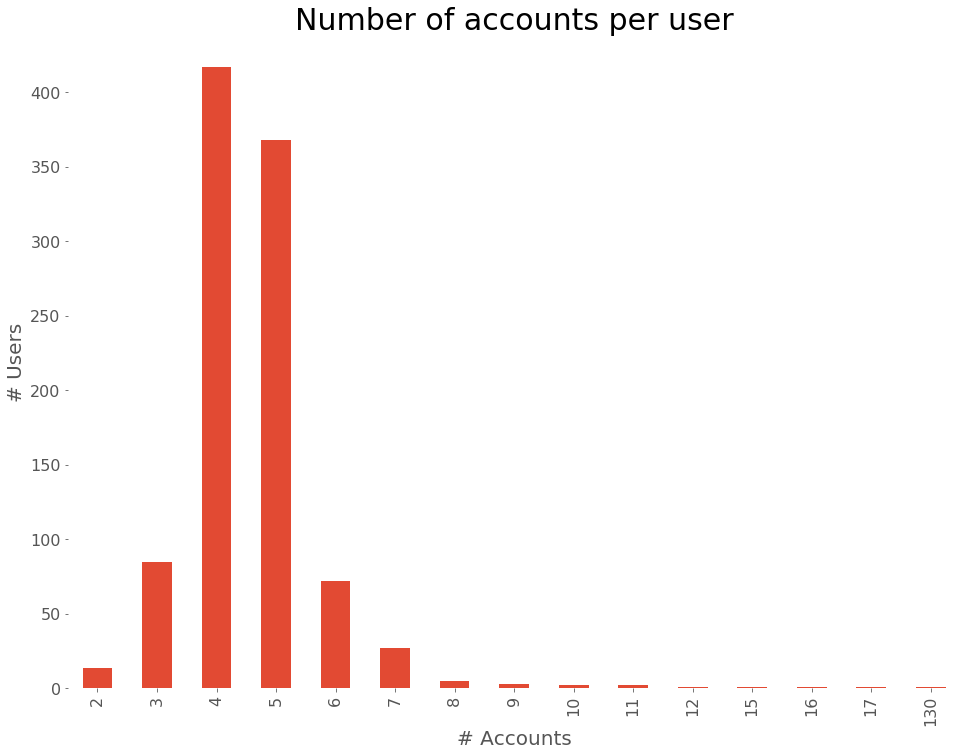

In [275]:
#### QUESTION 3: ####

query_string_3a = '''SELECT account_count, COUNT(1) 
FROM
(
    SELECT COUNT(distinct account_id) as account_count,
           user_id
    FROM accounts
    Group By user_id 

) agg_table
GROUP BY account_count'''

data_3a = []
with engine.connect() as con:
    rs = con.execute(query_string_3a)
    
    for row in rs:
        data_3a.append(row)
        
df_3a = pd.DataFrame(data_3a, columns = ['# Accounts', 'Count of Users']) 
df_3a.set_index('# Accounts',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    df_3a.plot(kind="bar", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("# Accounts", fontsize=20)
    ax.set_ylabel("# Users", fontsize=20)
plt.title('Number of accounts per user', fontsize=30)
plt.savefig('3a.png')
plt.savefig('3a.pdf')
print('Fun to note that one user has opened 130 accounts. Time to call the fraud department!')

2019-12-29 23:37:00,888 INFO sqlalchemy.engine.base.Engine SELECT currency_count, COUNT(1) 
FROM
(
    SELECT COUNT(distinct currency) as currency_count,
           user_id
    FROM accounts
    Group By user_id 

) agg_table
GROUP BY currency_count
2019-12-29 23:37:00,889 INFO sqlalchemy.engine.base.Engine ()
Hmm, seems like all users trade and sell with at least two currencies. Makes sense, you need USD to get started!


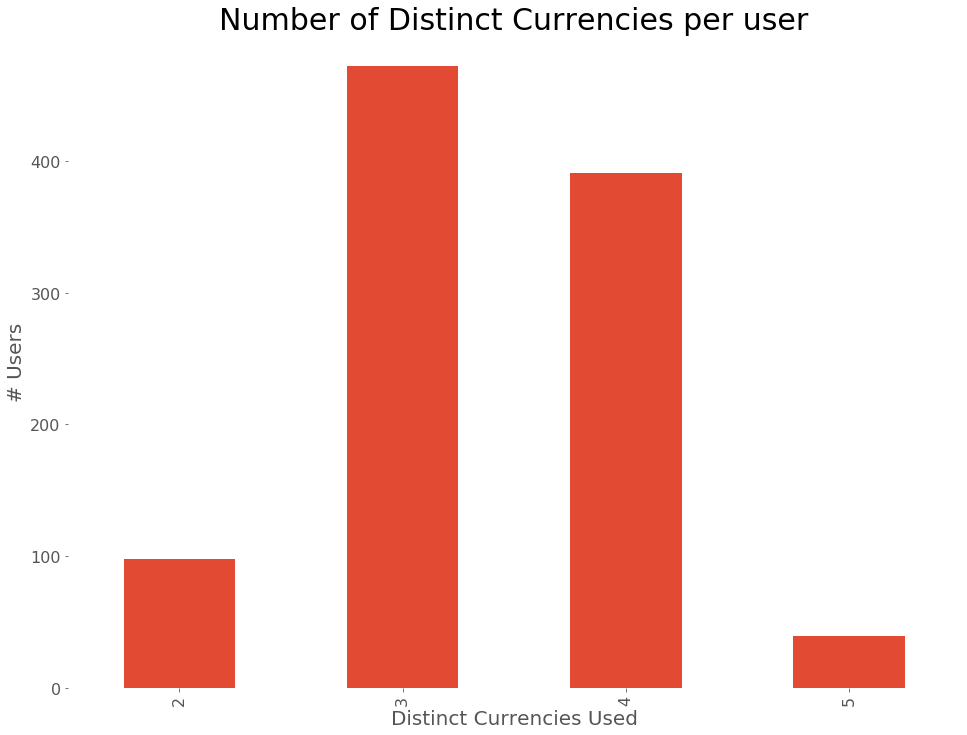

In [276]:
query_string_3b = '''SELECT currency_count, COUNT(1) 
FROM
(
    SELECT COUNT(distinct currency) as currency_count,
           user_id
    FROM accounts
    Group By user_id 

) agg_table
GROUP BY currency_count'''

data_3b = []
with engine.connect() as con:
    rs = con.execute(query_string_3b)
    
    for row in rs:
        data_3b.append(row)
        
df_3b = pd.DataFrame(data_3b, columns = ['# Distinct Currencies', 'Count of Users']) 
df_3b.set_index('# Distinct Currencies',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    df_3b.plot(kind="bar", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("Distinct Currencies Used", fontsize=20)
    ax.set_ylabel("# Users", fontsize=20)
plt.title('Number of Distinct Currencies per user', fontsize=30)
plt.savefig('3bb.png')
plt.savefig('3b.pdf')
print('Hmm, seems like all users trade and sell with at least two currencies. Makes sense, you need USD to get started!')

2019-12-29 23:37:10,435 INFO sqlalchemy.engine.base.Engine SELECT a.currency, sum(l.amount)
FROM accounts a
INNER JOIN ledger l ON a.account_id = l.account_id
GROUP BY a.currency
2019-12-29 23:37:10,435 INFO sqlalchemy.engine.base.Engine ()


Text(0.5, 1.0, 'User balances per currency')

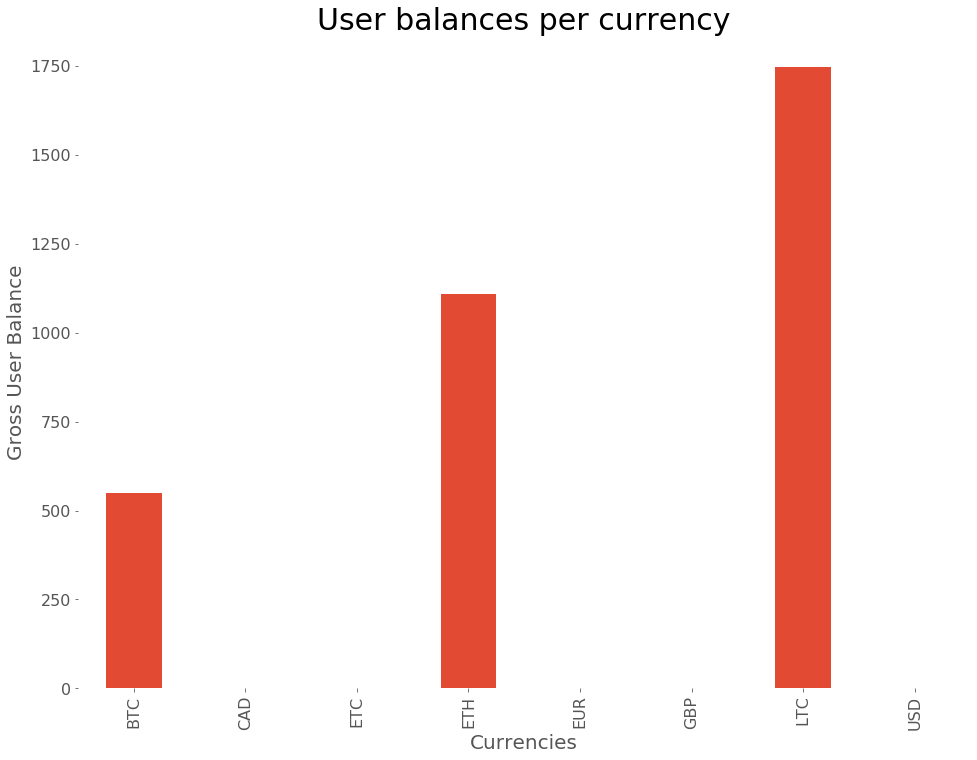

In [277]:
query_string_3c = '''SELECT a.currency, sum(l.amount)
FROM accounts a
INNER JOIN ledger l ON a.account_id = l.account_id
GROUP BY a.currency'''

data_3c = []
with engine.connect() as con:
    rs = con.execute(query_string_3c)
    
    for row in rs:
        data_3c.append(row)
        
df_3c = pd.DataFrame(data_3c, columns = ['Currency', 'User Balances']) 
df_3c.set_index('Currency',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    df_3c.plot(kind="bar", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("Currencies", fontsize=20)
    ax.set_ylabel("Gross User Balance", fontsize=20)
plt.title('User balances per currency', fontsize=30)
plt.savefig('3c.png')
plt.savefig('3c.pdf')

In [191]:
data_3c

[('BTC', 549.3704034000035),
 ('CAD', 0.0),
 ('ETC', 0.0),
 ('ETH', 1109.2560647299988),
 ('EUR', 0.04095604000000014),
 ('GBP', 0.0014984000000000028),
 ('LTC', 1747.181529089999),
 ('USD', 0.05242021999999985)]

2019-12-29 23:37:16,894 INFO sqlalchemy.engine.base.Engine SELECT days_before_first_deposit, COUNT(DISTINCT user_id)
FROM (SELECT u.user_id, 
            (julianday(SUBSTR(first_deposit, 1, 10))
            - julianday(SUBSTR(created_at, 1, 10))) AS days_before_first_deposit
        FROM users u
        INNER JOIN
            (SELECT u.user_id, MIN(l.created_at) AS first_deposit
            FROM users u
            INNER JOIN accounts a ON a.user_id = u.user_id
            INNER JOIN ledger l ON a.account_id = l.account_id
            WHERE l.amount > 0
            GROUP BY u.user_id
        ) fd ON u.user_id = fd.user_id) agg_table
GROUP BY days_before_first_deposit
2019-12-29 23:37:16,895 INFO sqlalchemy.engine.base.Engine ()
Very ugly! This is not a proper submission.


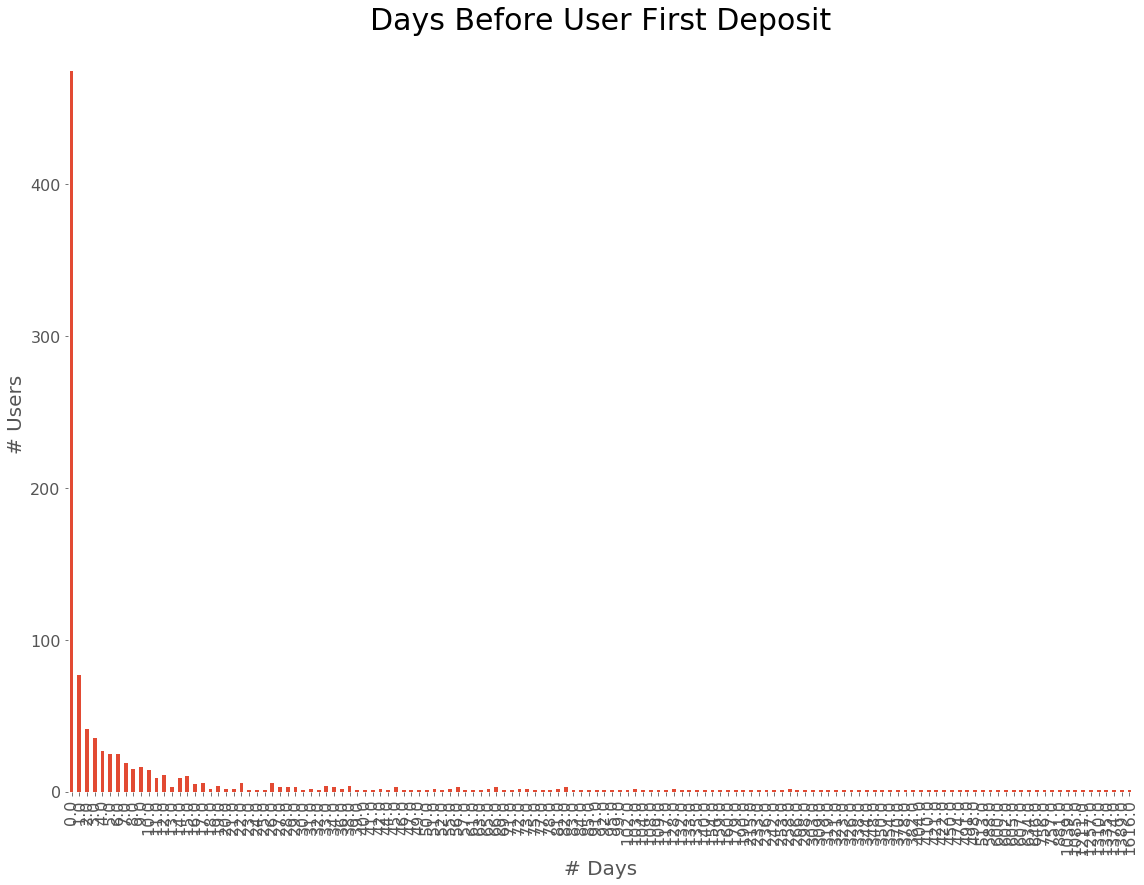

In [278]:
query_string_3d = '''SELECT days_before_first_deposit, COUNT(DISTINCT user_id)
FROM (SELECT u.user_id, 
            (julianday(SUBSTR(first_deposit, 1, 10))
            - julianday(SUBSTR(created_at, 1, 10))) AS days_before_first_deposit
        FROM users u
        INNER JOIN
            (SELECT u.user_id, MIN(l.created_at) AS first_deposit
            FROM users u
            INNER JOIN accounts a ON a.user_id = u.user_id
            INNER JOIN ledger l ON a.account_id = l.account_id
            WHERE l.amount > 0
            GROUP BY u.user_id
        ) fd ON u.user_id = fd.user_id) agg_table
GROUP BY days_before_first_deposit'''

data_3d = []
with engine.connect() as con:
    rs = con.execute(query_string_3d)
    
    for row in rs:
        data_3d.append(row)

df_3d = pd.DataFrame(data_3d, columns = ['# Days', '# Users']) 
df_3d.set_index('# Days',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    df_3d.plot(kind="bar", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("# Days", fontsize=20)
    ax.set_ylabel("# Users", fontsize=20)
plt.tight_layout()
plt.title('Days Before User First Deposit', fontsize=30)
print('Very ugly! This is not a proper submission.')

Big head and long tail. Bucketization is the way!


Text(0.5, 1, 'Days Before User First Deposit')

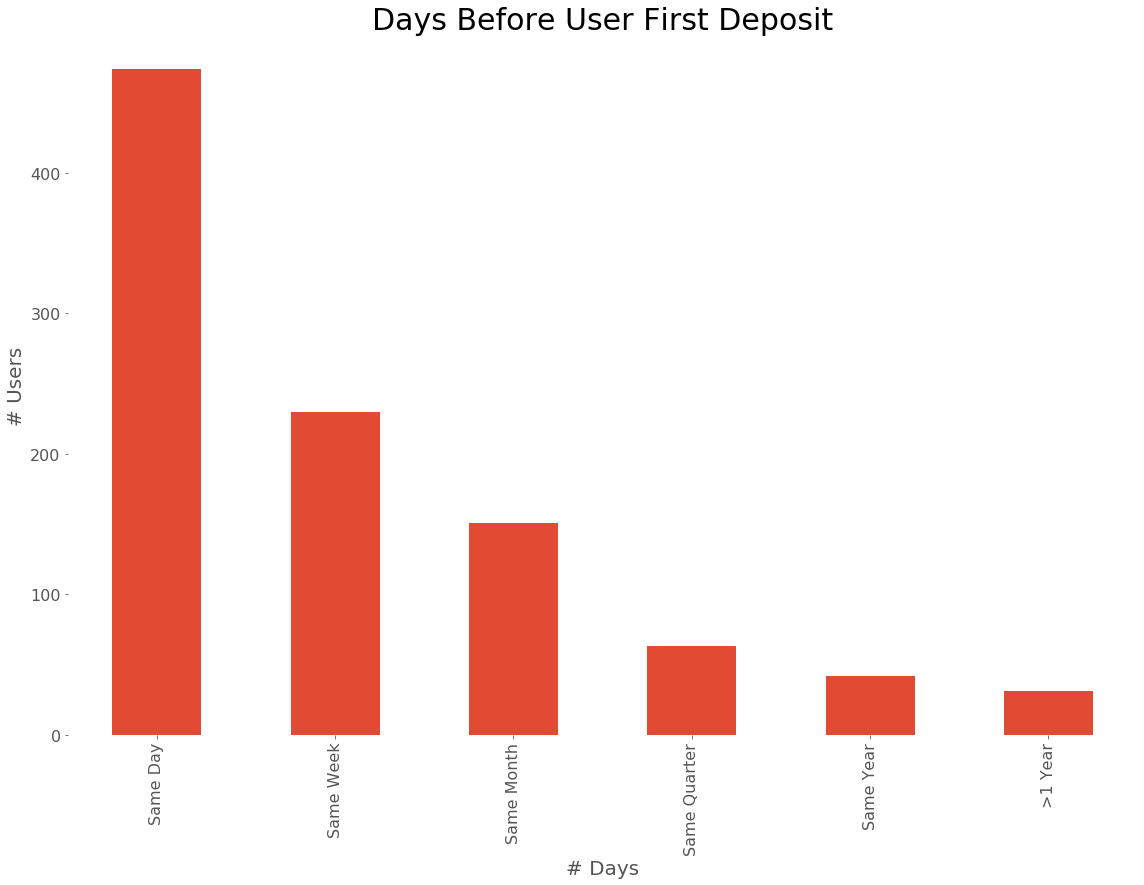

In [279]:
print('Big head and long tail. Bucketization is the way!')
bucket_3d = {}
for user in data_3d:
    if user[0] == 0:
        bucket_3d['Same Day'] = user[1]
    elif user[0] < 7:
        bucket_3d['Same Week'] = bucket_3d.get('Same Week', 0) + user[1]
    elif user[0] < 30:
        bucket_3d['Same Month'] = bucket_3d.get('Same Month', 0) + user[1]
    elif user[0] < 90:
        bucket_3d['Same Quarter'] = bucket_3d.get('Same Quarter', 0) + user[1]
    elif user[0] < 360:
        bucket_3d['Same Year'] = bucket_3d.get('Same Year', 0) + user[1]
    else:
        bucket_3d['>1 Year'] = bucket_3d.get('>1 Year', 0) + user[1]

bucket_df_3d = pd.DataFrame(list(bucket_3d.items()), columns = ['# Days', '# Users']) 
bucket_df_3d.set_index('# Days',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    bucket_df_3d.plot(kind="bar", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("# Days", fontsize=20)
    ax.set_ylabel("# Users", fontsize=20)
plt.tight_layout()
plt.title('Days Before User First Deposit', fontsize=30)

plt.savefig('3d.png')
plt.savefig('3d.pdf')

2019-12-29 23:37:35,814 INFO sqlalchemy.engine.base.Engine SELECT days_between_fd_and_fw, COUNT(DISTINCT user_id)
        FROM (SELECT u.user_id, 
            abs(julianday(SUBSTR(first_deposit, 1, 10)) 
                - julianday(SUBSTR(first_withdrawal, 1, 10))) AS days_between_fd_and_fw
        FROM users u
        INNER JOIN
            (SELECT u.user_id, MIN(l.created_at) AS first_deposit
            FROM users u
            INNER JOIN accounts a ON a.user_id = u.user_id
            INNER JOIN ledger l ON a.account_id = l.account_id
            WHERE l.amount > 0
            GROUP BY u.user_id
        ) fd ON u.user_id = fd.user_id
        INNER JOIN
            (SELECT u.user_id, MIN(l.created_at) AS first_withdrawal
            FROM users u
            INNER JOIN accounts a ON a.user_id = u.user_id
            INNER JOIN ledger l ON a.account_id = l.account_id
            WHERE l.amount < 0
            GROUP BY u.user_id
        ) fw ON u.user_id = fw.user_id) agg_table
GROUP B

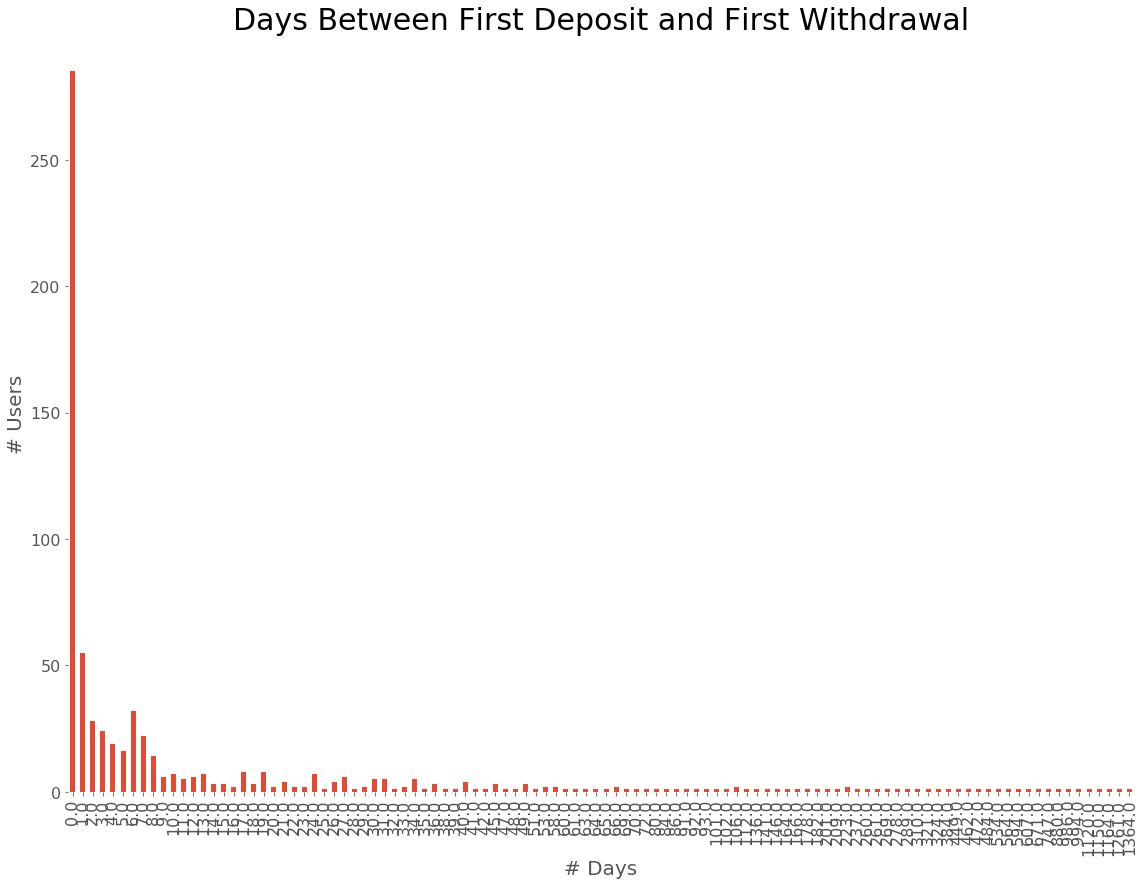

In [281]:
query_string_3e = '''SELECT days_between_fd_and_fw, COUNT(DISTINCT user_id)
        FROM (SELECT u.user_id, 
            abs(julianday(SUBSTR(first_deposit, 1, 10)) 
                - julianday(SUBSTR(first_withdrawal, 1, 10))) AS days_between_fd_and_fw
        FROM users u
        INNER JOIN
            (SELECT u.user_id, MIN(l.created_at) AS first_deposit
            FROM users u
            INNER JOIN accounts a ON a.user_id = u.user_id
            INNER JOIN ledger l ON a.account_id = l.account_id
            WHERE l.amount > 0
            GROUP BY u.user_id
        ) fd ON u.user_id = fd.user_id
        INNER JOIN
            (SELECT u.user_id, MIN(l.created_at) AS first_withdrawal
            FROM users u
            INNER JOIN accounts a ON a.user_id = u.user_id
            INNER JOIN ledger l ON a.account_id = l.account_id
            WHERE l.amount < 0
            GROUP BY u.user_id
        ) fw ON u.user_id = fw.user_id) agg_table
GROUP BY days_between_fd_and_fw'''

data_3e = []
with engine.connect() as con:
    rs = con.execute(query_string_3e)
    
    for row in rs:
        data_3e.append(row)

df_3e = pd.DataFrame(data_3e, columns = ['# Days', '# Users']) 
df_3e.set_index('# Days',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    df_3e.plot(kind="bar", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("# Days", fontsize=20)
    ax.set_ylabel("# Users", fontsize=20)
plt.tight_layout()
plt.title('Days Between First Deposit and First Withdrawal', fontsize=30)
print('Same issue. Very ugly! This is not a proper submission.')

Big head and long tail. Bucketization is the way!


Text(0.5, 1, 'Days Between First Deposit and First Withdrawal')

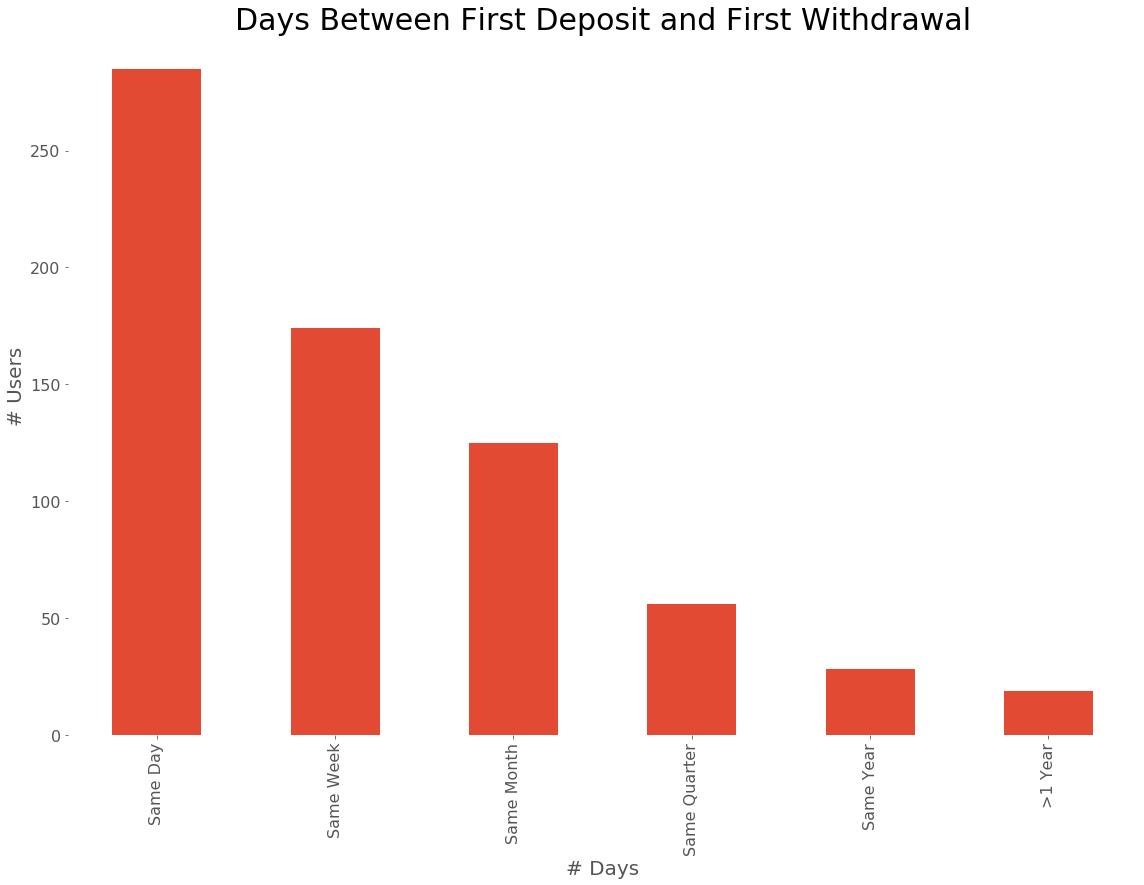

In [282]:
print('Big head and long tail. Bucketization is the way!')
bucket_3e = {}
for user in data_3e:
    if user[0] == 0:
        bucket_3e['Same Day'] = user[1]
    elif user[0] < 7:
        bucket_3e['Same Week'] = bucket_3e.get('Same Week', 0) + user[1]
    elif user[0] < 30:
        bucket_3e['Same Month'] = bucket_3e.get('Same Month', 0) + user[1]
    elif user[0] < 90:
        bucket_3e['Same Quarter'] = bucket_3e.get('Same Quarter', 0) + user[1]
    elif user[0] < 360:
        bucket_3e['Same Year'] = bucket_3e.get('Same Year', 0) + user[1]
    else:
        bucket_3e['>1 Year'] = bucket_3e.get('>1 Year', 0) + user[1]

bucket_df_3e = pd.DataFrame(list(bucket_3e.items()), columns = ['# Days', '# Users']) 
bucket_df_3e.set_index('# Days',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    bucket_df_3e.plot(kind="bar", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("# Days", fontsize=20)
    ax.set_ylabel("# Users", fontsize=20)
plt.tight_layout()
plt.title('Days Between First Deposit and First Withdrawal', fontsize=30)

plt.savefig('3e.png')
plt.savefig('3e.pdf')

In [283]:
#### QUESTION 4: ####

# query_string_4s = '''DROP TABLE account_ending_balances'''

query_string_4 = '''CREATE TABLE account_ending_balances
                    AS SELECT a.account_id AS account_id, sum(l.amount) AS ending_balance
                        FROM accounts a 
                        INNER JOIN ledger l ON a.account_id = l.account_id
                        GROUP BY a.account_id'''

query_string_4b = '''SELECT * FROM account_ending_balances'''

data_4 = []
with engine.connect() as con:
#     con.execute(query_string_4s)
    con.execute(query_string_4)
    rs = con.execute(query_string_4b)
    
    for row in rs:
        data_4.append(row)
        

2019-12-29 23:37:49,045 INFO sqlalchemy.engine.base.Engine CREATE TABLE account_ending_balances
                    AS SELECT a.account_id AS account_id, sum(l.amount) AS ending_balance
                        FROM accounts a 
                        INNER JOIN ledger l ON a.account_id = l.account_id
                        GROUP BY a.account_id
2019-12-29 23:37:49,045 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:37:49,074 INFO sqlalchemy.engine.base.Engine COMMIT
2019-12-29 23:37:49,075 INFO sqlalchemy.engine.base.Engine SELECT * FROM account_ending_balances
2019-12-29 23:37:49,076 INFO sqlalchemy.engine.base.Engine ()


In [319]:
#### QUESTION 5: ####

query_string_5 = '''CREATE TABLE account_daily_balances
                    AS SELECT a.account_id,
                           SUBSTR(l.created_at, 1, 10) AS l_date,
                           SUM(l.amount) OVER(ORDER BY l.created_at) RunningTotal
                    FROM accounts a
                    INNER JOIN ledger l ON a.account_id = l.account_id
                    GROUP BY a.account_id, l_date
                    ORDER BY l.ledger_entry_id'''
query_string_5b = '''SELECT * FROM account_daily_balances'''

data_5 = []
with engine.connect() as con:
    con.execute(query_string_5)
    rs = con.execute(query_string_5b)
    
    for row in rs:
        data_5.append(row)

2019-12-30 00:32:25,520 INFO sqlalchemy.engine.base.Engine CREATE TABLE account_daily_balances
                    AS SELECT a.account_id,
                           SUBSTR(l.created_at, 1, 10) AS l_date,
                           SUM(l.amount) OVER(ORDER BY l.created_at) RunningTotal
                    FROM accounts a
                    INNER JOIN ledger l ON a.account_id = l.account_id
                    GROUP BY a.account_id, l_date
                    ORDER BY l.ledger_entry_id
2019-12-30 00:32:25,521 INFO sqlalchemy.engine.base.Engine ()
2019-12-30 00:32:25,628 INFO sqlalchemy.engine.base.Engine COMMIT
2019-12-30 00:32:25,629 INFO sqlalchemy.engine.base.Engine SELECT * FROM account_daily_balances
2019-12-30 00:32:25,630 INFO sqlalchemy.engine.base.Engine ()


In [330]:
#### QUESTION 6: ####
# Is this 'total' referring to total for each individual user? Or account? Or TOTAL total?

query_string_6 = '''SELECT l.ledger_entry_id,
                           abs(l.amount) / abs(sum(l.amount))
                    FROM ledger l
                    WHERE l.amount < 0'''

data_6 = []
with engine.connect() as con:
    rs = con.execute(query_string_6)
    
    for row in rs:
        data_6.append(row)


2019-12-30 02:35:15,569 INFO sqlalchemy.engine.base.Engine SELECT l.ledger_entry_id,
                           abs(l.amount) / abs(sum(l.amount))
                    FROM ledger l
                    WHERE l.amount < 0
2019-12-30 02:35:15,570 INFO sqlalchemy.engine.base.Engine ()


In [331]:
data_6

[('9e341acdd92537be85bef93b6fec313b', 1.4867936408489173e-06)]

In [328]:
#### QUESTION 6: ####
# Is this 'total' referring to total for each individual user? Or account? Or TOTAL total?

query_string_6 = '''SELECT l.ledger_entry_id,
                           l.amount / tw.total_withdrawn
                    FROM ledger l
                    INNER JOIN (SELECT l.ledger_entry_id, 
                                       abs(sum(l.amount)) AS total_withdrawn
                            FROM ledger l
                            WHERE l.amount < 0
                       ) tw ON l.ledger_entry_id = tw.ledger_entry_id
                       WHERE l.amount < 0'''

data_6 = []
with engine.connect() as con:
    rs = con.execute(query_string_6)
    
    for row in rs:
        data_6.append(row)


2019-12-30 02:34:06,432 INFO sqlalchemy.engine.base.Engine SELECT l.ledger_entry_id,
                           l.amount / tw.total_withdrawn
                    FROM ledger l
                    INNER JOIN (SELECT l.ledger_entry_id, 
                                       abs(sum(l.amount)) AS total_withdrawn
                            FROM ledger l
                            WHERE l.amount < 0
                       ) tw ON l.ledger_entry_id = tw.ledger_entry_id
                       WHERE l.amount < 0
2019-12-30 02:34:06,433 INFO sqlalchemy.engine.base.Engine ()


In [287]:
#### QUESTION 7: ####

import requests
from bs4 import BeautifulSoup

url = 'https://www.coinbase.com/price'
r = requests.get(url)
crypto_soup = BeautifulSoup(r.content, 'html.parser')
crypto_soup_rows = soup.select('tbody tr')

from re import sub
from decimal import Decimal

class CryptoPrices(Base):
    __tablename__ = 'cryptoprices'
    currency_name = Column(String, primary_key=True)
    value_in_usd = Column(Numeric)

CryptoPrices.__table__.create(bind=engine, checkfirst=True)

for csr in crypto_soup_rows:
    try: 
        currency_name = csr.findAll('h4')[2].text
        currency_val = Decimal(sub(r'[^\d.]', '', csr.findAll('h4')[3].text))
        crypto_dict = {'currency_name': currency_name, 'value_in_usd': currency_val}
        crypto_row = CryptoPrices(**crypto_dict)
        session.add(crypto_row)
    except:
        # the 18th row is a header: "Not available on Coinbase"
        pass

session.commit()

2019-12-29 23:38:27,962 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("cryptoprices")
2019-12-29 23:38:27,963 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:38:27,964 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("cryptoprices")
2019-12-29 23:38:27,965 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:38:27,965 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE cryptoprices (
	currency_name VARCHAR NOT NULL, 
	value_in_usd NUMERIC, 
	PRIMARY KEY (currency_name)
)


2019-12-29 23:38:27,966 INFO sqlalchemy.engine.base.Engine ()
2019-12-29 23:38:27,968 INFO sqlalchemy.engine.base.Engine COMMIT


2019-12-30 00:39:50,760 INFO sqlalchemy.engine.base.Engine SELECT SUBSTR(cat.created_at, 1, 10) AS l_date,
                            SUM(crypto_asset_value) OVER(ORDER BY cat.created_at) AS crypto_asset_total
                    FROM (SELECT l.ledger_entry_id,
                                       l.created_at,
                                       (l.amount * cp.value_in_usd) AS crypto_asset_value
                                FROM ledger l
                                INNER JOIN accounts a ON l.account_id = a.account_id 
                                INNER JOIN cryptoprices cp ON a.currency = cp.currency_name
                                WHERE a.currency not in ('USD','EUR','CAD','GBP') -- only crypto
                        ) cat 
                    GROUP BY l_date
2019-12-30 00:39:50,761 INFO sqlalchemy.engine.base.Engine ()


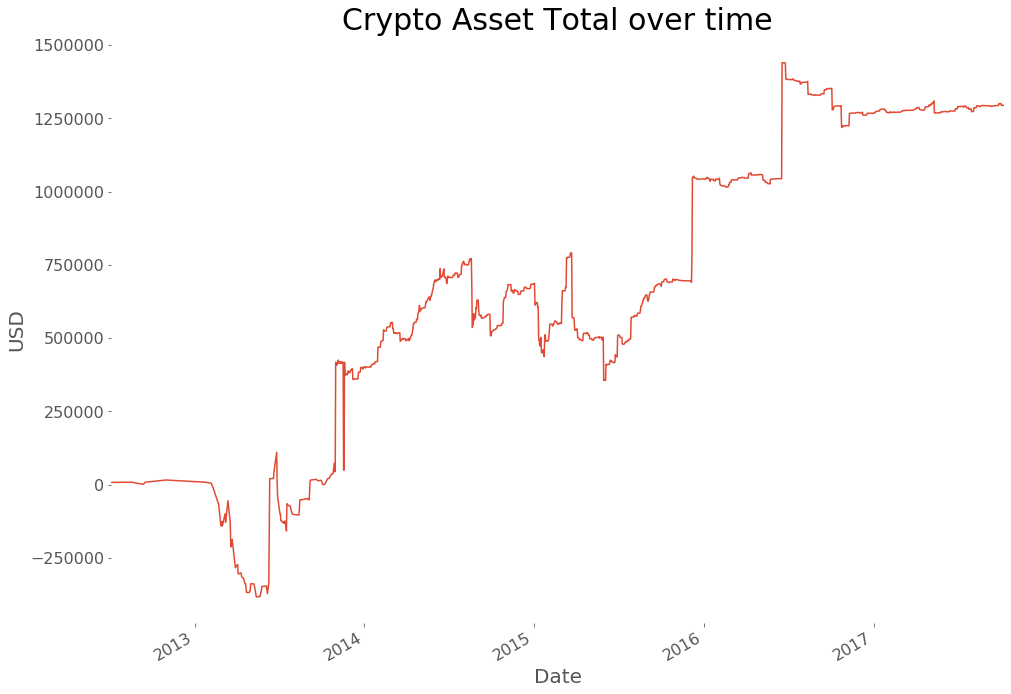

In [324]:
query_string_7a = '''SELECT SUBSTR(cat.created_at, 1, 10) AS l_date,
                            SUM(crypto_asset_value) OVER(ORDER BY cat.created_at) AS crypto_asset_total
                    FROM (SELECT l.ledger_entry_id,
                                       l.created_at,
                                       (l.amount * cp.value_in_usd) AS crypto_asset_value
                                FROM ledger l
                                INNER JOIN accounts a ON l.account_id = a.account_id 
                                INNER JOIN cryptoprices cp ON a.currency = cp.currency_name
                                WHERE a.currency not in ('USD','EUR','CAD','GBP') -- only crypto
                        ) cat 
                    GROUP BY l_date'''

data_7a = []
with engine.connect() as con:
    rs = con.execute(query_string_7a)
    
    for row in rs:
        row_date = datetime.strptime(row[0], '%Y-%m-%d')
        data_7a.append([row_date,row[1]])

df_7a = pd.DataFrame(data_7a, columns = ['Date', 'Crypto Asset Total']) 
df_7a.set_index('Date',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    df_7a.plot(kind="line", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("Date", fontsize=20)
    ax.set_ylabel("USD", fontsize=20)
plt.title('Crypto Asset Total over time', fontsize=30)
plt.savefig('7a.png')
plt.savefig('7a.pdf')

2019-12-30 00:39:54,324 INFO sqlalchemy.engine.base.Engine SELECT SUBSTR(cat.created_at, 1, 10) AS l_date,
                           SUM(asset_value) AS asset_total
                    FROM (SELECT l.ledger_entry_id,
                                       l.created_at,
                                       (l.amount * CASE 
                                           WHEN a.currency = 'USD' THEN 1
                                           WHEN a.currency = 'CAD' THEN 0.76
                                           WHEN a.currency = 'EUR' THEN 1.12
                                           WHEN a.currency = 'GBP' THEN 1.31
                                           ELSE cp.value_in_usd END) AS asset_value
                                FROM ledger l
                                INNER JOIN accounts a ON l.account_id = a.account_id 
                                INNER JOIN cryptoprices cp ON a.currency = cp.currency_name
                            ) cat 
                    GROU

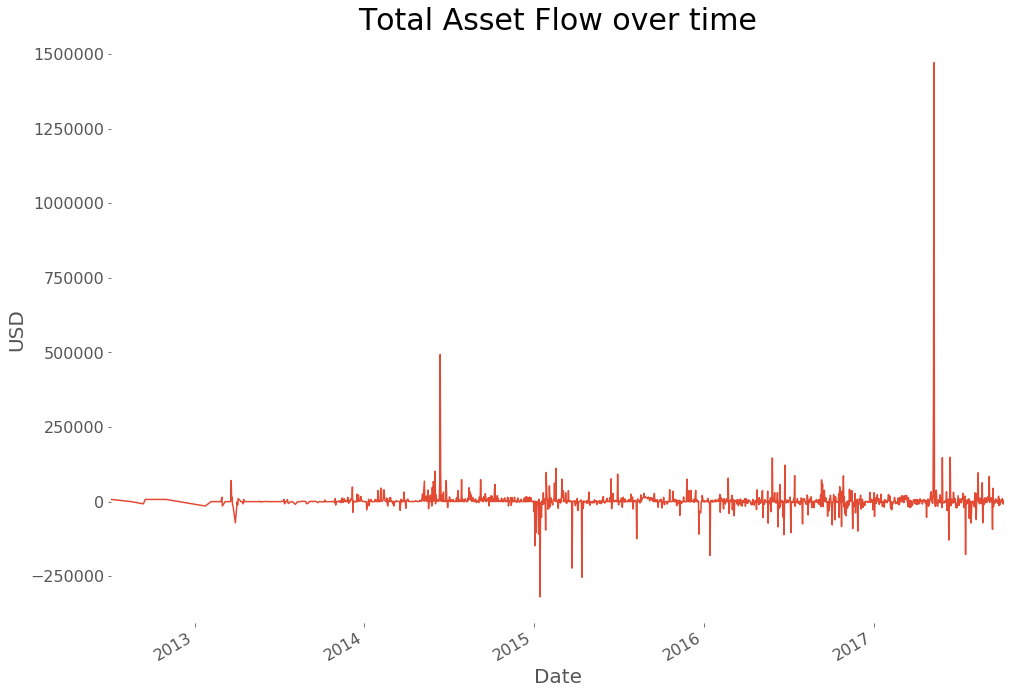

In [325]:
query_string_7b = '''SELECT SUBSTR(cat.created_at, 1, 10) AS l_date,
                           SUM(asset_value) AS asset_total
                    FROM (SELECT l.ledger_entry_id,
                                       l.created_at,
                                       (l.amount * CASE 
                                           WHEN a.currency = 'USD' THEN 1
                                           WHEN a.currency = 'CAD' THEN 0.76
                                           WHEN a.currency = 'EUR' THEN 1.12
                                           WHEN a.currency = 'GBP' THEN 1.31
                                           ELSE cp.value_in_usd END) AS asset_value
                                FROM ledger l
                                INNER JOIN accounts a ON l.account_id = a.account_id 
                                INNER JOIN cryptoprices cp ON a.currency = cp.currency_name
                            ) cat 
                    GROUP BY l_date'''

data_7b = []
with engine.connect() as con:
    rs = con.execute(query_string_7b)
    
    for row in rs:
        row_date = datetime.strptime(row[0], '%Y-%m-%d')
        data_7b.append([row_date,row[1]])

df_7b = pd.DataFrame(data_7b, columns = ['Date', 'Asset Total']) 
df_7b.set_index('Date',drop=True,inplace=True)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,12))
    ax.tick_params(labelsize=16)
    df_7b.plot(kind="line", legend=False, ax=ax)
    ax.set_frame_on(False)
    ax.set_xlabel("Date", fontsize=20)
    ax.set_ylabel("USD", fontsize=20)
plt.title('Total Asset Flow over time', fontsize=30)
plt.savefig('7b.png')
plt.savefig('7b.pdf')

In [ ]:
## Footnotes: thought experiments and other implementations

# Hmm, should some of these be left joins...?
# USING instead of account_id = account_id

# Question 7: The prompt called for a table to be created. 
# That's easily done with a pandas df, but a python dictionary would be more efficient.

# Pandas table implementation
data_7 = [['Currency','Value in USD']]
i = 0
for row in rows:
    try: 
        currency_name = row.findAll('h4')[2].text
        currency_val = Decimal(sub(r'[^\d.]', '', row.findAll('h4')[3].text))
        data_7.append([currency_name,currency_val])
    except:
        # the 18th row is a header: "Not available on Coinbase"
        pass
df_7 = pd.DataFrame(data_7[1:],columns=data_7[0])

# Python dictionary implementation
crypto_dict = {}
for row in rows:
    try: 
        crypto_dict[row.findAll('h4')[2].text] = Decimal(sub(r'[^\d.]', '', row.findAll('h4')[3].text))
    except:
        # the 18th index row is a header: "Not available on Coinbase"
        pass

# Print some checks
print("Why, a Bitcoin is worth a mint ${}, old sport!".format(crypto_dict['BTC']*1))
print("And a single ether fetches ${} in today's economy!".format(df_7.loc[df_7['Currency'] == 'ETH', 'Value in USD'].iloc[0]*1))